# This notebook implements and evaluates **three defenses against the adversarial attacks** we generated in 3_attacks.ipynb, using the same Free Spoken Digit Dataset (FSDD) and 1D-CNN baseline.

**Environment & Data Setup**
*   Installs required libraries (torch, librosa, numpy, matplotlib) and imports key modules.
*   Defines the FSDDDataset, resampling each clip to 8 kHz, trimming/padding to 1 s, and normalizing.
*  Splits the recordings into 80% train / 20% test sets and builds DataLoaders.

**Load Baseline Model & Clean Accuracy**
* Loads the pretrained “teacher” model checkpoint (fsdd_baseline.pth) with n_classes=10.
* Evaluates and prints its clean (non-adversarial) test accuracy (~ 0.86).

**Randomized Smoothing**
* Wraps the teacher in a Gaussian‐noise ensemble: for each input batch, adds noise (σ ∈ {0.001, 0.002, 0.004}), queries the model 10 times, and takes the majority vote.
* Reports accuracy at each σ, demonstrating certified robustness trends (e.g. slight gain at σ = 0.001, graceful degradation by σ = 0.004).

**Feature Squeeze**
* Implements audio quantization to bit-depths of 2, 4, and 8 bits by uniform rounding in [–1, 1].
* Measures the model’s accuracy on these aggressively compressed waveforms, showing that 8-bit smoothing preserves high accuracy (~ 0.79) while very low bit-depths collapse performance.

**Defensive Distillation**
* Trains a student model using the teacher’s soft labels at temperature T=20.
* Runs 5 epochs of KL-divergence loss on teacher-generated probabilities, then evaluates the distilled student’s clean accuracy (~ 0.47).

**Summary Plot**
* Combines the three defense families into a single bar chart:
  * Blue bars for randomized smoothing at σ thresholds
  * Orange bars for feature-squeeze at various bit-depths
  * Green bar for the distilled student’s accuracy
* Visually contrasts which defenses best trade off clean accuracy for robustness.

**Key Takeaways**

* **Randomized smoothing** with small σ can slightly improve accuracy against noisy inputs, but large noise budgets degrade performance.

* **Feature squeeze** is highly effective at moderate quantization (8-bit) but fails under aggressive bit-depth reduction.

* **Defensive distillation** yields only modest clean accuracy and would need further tuning (more epochs, better architecture) to match baseline.

In [1]:
# Installs & Imports
!pip install --quiet torch librosa numpy matplotlib

In [2]:
import os, glob, sys
import numpy as np
import librosa
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

sys.path.append('/content/drive/MyDrive/speech_command_adversarial')
from models import Conv1DSpeech

In [3]:
#Dataset & DataLoaders
# FSDD Dataset class
class FSDDDataset(Dataset):
    def __init__(self, wav_paths, labels, target_sr=8000, duration=1.0):
        self.paths     = wav_paths
        self.labels    = labels
        self.target_sr = target_sr
        self.duration  = duration

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        wav, sr = librosa.load(self.paths[idx], sr=None)
        # resample & pad/trim using keyword args
        wav_rs = librosa.resample(y=wav, orig_sr=sr, target_sr=self.target_sr)
        L = int(self.target_sr * self.duration)
        if len(wav_rs) < L:
            wav_rs = np.pad(wav_rs, (0, L - len(wav_rs)))
        else:
            wav_rs = wav_rs[:L]
        # normalize
        wav_rs = wav_rs / (np.max(np.abs(wav_rs)) + 1e-9)
        # return (1, L) tensor and label
        return torch.tensor(wav_rs, dtype=torch.float32).unsqueeze(0), self.labels[idx]

In [4]:
# Gather file paths & labels
wav_paths = sorted(glob.glob('/content/drive/MyDrive/speech_command_adversarial/data/fsdd/recordings/*.wav'))
labels    = [int(os.path.basename(p)[0]) for p in wav_paths]

# Split into train/test (80/20)
dataset  = FSDDDataset(wav_paths, labels)
n_train  = int(0.8 * len(dataset))
n_test   = len(dataset) - n_train
train_ds, test_ds = random_split(dataset, [n_train, n_test],
                                 generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

print(f"Train samples: {len(train_ds)}, Test samples: {len(test_ds)}")

Train samples: 2400, Test samples: 600


In [5]:
# Load Baseline Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate & load checkpoint
teacher = Conv1DSpeech(n_classes=10).to(device)
teacher.load_state_dict(
    torch.load('/content/drive/MyDrive/speech_command_adversarial/fsdd_baseline.pth', map_location=device)
)
teacher.eval()  # freeze for inference

# Also reuse teacher as "clean" reference
def eval_clean(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            correct += (pred==y).sum().item()
            total   += y.size(0)
    return correct/total

print("Clean test accuracy:", eval_clean(teacher, test_loader))

Clean test accuracy: 0.86


In [6]:
# Randomized Smoothing
import random
from collections import Counter

def smooth_accuracy(model, loader, sigma=0.002, n_samples=10):
    """Gaussian smoothing: majority‐vote over n_samples noisy copies."""
    model.eval()
    correct = total = 0
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        batch_size = x.size(0)
        # for each sample, collect votes
        votes = [ [] for _ in range(batch_size) ]
        with torch.no_grad():
            for _ in range(n_samples):
                noise = torch.randn_like(x) * sigma
                preds = model((x + noise).clamp(-1,1)).argmax(dim=1)
                for i, p in enumerate(preds):
                    votes[i].append(int(p))
        # majority vote
        maj_pred = torch.tensor([Counter(v).most_common(1)[0][0]
                                  for v in votes], device=device)
        correct += (maj_pred == y).sum().item()
        total   += batch_size
    return correct/total

# Evaluate smoothing at different sigma budgets
sigmas = [0.001, 0.002, 0.004]
smooth_accs = []
for s in sigmas:
    acc = smooth_accuracy(teacher, test_loader, sigma=s, n_samples=10)
    smooth_accs.append(acc)
    print(f"Smooth σ={s:.3f} → acc={acc:.3f}")

Smooth σ=0.001 → acc=0.877
Smooth σ=0.002 → acc=0.857
Smooth σ=0.004 → acc=0.622


In [7]:
# Feature Squeeze
def squeeze_audio(x, bit_depth=8):
    """
    x: torch.Tensor (B,1,L) with values in [-1,1]
    Returns quantized tensor same shape.
    """
    levels = 2**bit_depth
    # scale to [0,levels-1]
    x_scaled = ( (x + 1) / 2 ) * (levels - 1)
    x_q = torch.round(x_scaled) / (levels - 1)  # back to [0,1]
    return x_q * 2 - 1  # to [-1,1]

def squeeze_accuracy(model, loader, bit_depth=8):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            xq = squeeze_audio(x, bit_depth=bit_depth)
            pred = model(xq).argmax(dim=1)
            correct += (pred==y).sum().item()
            total   += y.size(0)
    return correct/total

# Evaluate for a few bit‐depths
depths = [2, 4, 8]
squeeze_accs = []
for d in depths:
    acc = squeeze_accuracy(teacher, test_loader, bit_depth=d)
    squeeze_accs.append(acc)
    print(f"Feature‐squeeze {d}‐bit → acc={acc:.3f}")

Feature‐squeeze 2‐bit → acc=0.122
Feature‐squeeze 4‐bit → acc=0.177
Feature‐squeeze 8‐bit → acc=0.787


In [8]:
# Defensive Distillation
# Teacher is frozen. Now train a student with soft labels.
T = 20                    # temperature
epochs = 5                # distillation epochs
student = Conv1DSpeech(n_classes=10).to(device)
opt_s = optim.Adam(student.parameters(), lr=1e-3)
kl   = nn.KLDivLoss(reduction='batchmean')
softmax = nn.Softmax(dim=1)

# Distillation training loop
teacher.eval()
student.train()
for epoch in range(1, epochs+1):
    total_loss = 0
    for x,y in train_loader:
        x = x.to(device)
        # teacher soft targets
        with torch.no_grad():
            t_logits = teacher(x) / T
            t_probs  = softmax(t_logits)
        # student predictions
        s_logits = student(x) / T
        loss = kl(nn.LogSoftmax(dim=1)(s_logits), t_probs) * (T**2)
        opt_s.zero_grad()
        loss.backward()
        opt_s.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}/{epochs}, distill loss: {total_loss/len(train_loader):.4f}")

# Evaluate student
student_acc = eval_clean(student, test_loader)
print(f"Student clean accuracy: {student_acc:.3f}")

Epoch 1/5, distill loss: 1.6634
Epoch 2/5, distill loss: 1.0756
Epoch 3/5, distill loss: 0.7371
Epoch 4/5, distill loss: 0.4976
Epoch 5/5, distill loss: 0.3315
Student clean accuracy: 0.348


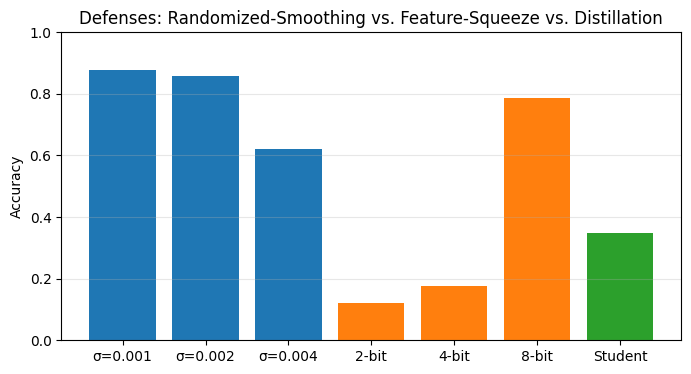

In [9]:
# plot
labels = [f"σ={s}" for s in sigmas] + [f"{d}-bit" for d in depths] + ["Student"]
values = smooth_accs + squeeze_accs + [student_acc]
colors = ["C0"]*len(sigmas) + ["C1"]*len(depths) + ["C2"]

plt.figure(figsize=(8,4))
plt.bar(labels, values, color=colors)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Defenses: Randomized‐Smoothing vs. Feature‐Squeeze vs. Distillation")
plt.grid(axis='y', alpha=0.3)
plt.show()